In [315]:
import torch
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
import sklearn

# Для исследования возьмем тикер MSFT, период - 1 год
Прогноз столбца Close на **1 период вперед**  
Весь датасет разделим на обучающую и тестовую выборки (70% и 30% соответственное)

In [328]:
import yfinance as yf

msft = yf.Ticker("MSFT") #Выбираем тикер

# get historical market data
hist = msft.history(period="1y") #Выбираем период

hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-11-25 00:00:00-05:00,245.136409,246.514192,244.561504,245.314835,9200800,0.0,0.0
2022-11-28 00:00:00-05:00,243.917217,244.482199,238.683623,239.635178,24778200,0.0,0.0
2022-11-29 00:00:00-05:00,239.278331,240.656114,236.116380,238.217743,17956300,0.0,0.0
2022-11-30 00:00:00-05:00,238.455632,253.085900,237.751865,252.897568,47594200,0.0,0.0
2022-12-01 00:00:00-05:00,251.638738,253.868963,248.714668,252.451538,26041500,0.0,0.0
...,...,...,...,...,...,...,...
2023-11-17 00:00:00-05:00,373.609985,374.369995,367.000000,369.850006,40157000,0.0,0.0
2023-11-20 00:00:00-05:00,371.220001,378.869995,371.000000,377.440002,52465100,0.0,0.0
2023-11-21 00:00:00-05:00,375.670013,376.220001,371.119995,373.070007,28423100,0.0,0.0


<Axes: xlabel='Date'>

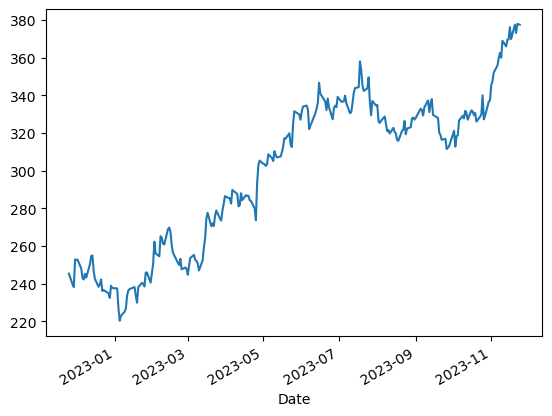

In [329]:
hist['Close'].plot()

In [330]:
timeseries = hist['Close'].values.astype('float32')
# train-test split 
train_size = int(len(timeseries) * 0.8)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]


In [322]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(np.array(X)), torch.tensor(np.array(y))

In [323]:
 
class AirModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear1 = nn.Linear(hidden_size, 10)
        self.linear2 = nn.Linear(10, 1)
        self.linear = nn.Linear(input_size, input_size)
    def forward(self, x):
        x = self.linear(x)
        x, _ = self.lstm(x)
        x = self.linear1(x)
        x = self.linear2(x)
        return x

# Прогноз по двум предыдущим периодам

Epoch 0: train MSE 85865.9766, test MSE 115273.1953
Epoch 100: train MSE 56724.2891, test MSE 80901.8047
Epoch 200: train MSE 19642.1680, test MSE 34233.3203
Epoch 300: train MSE 2570.2490, test MSE 7285.5996
Epoch 400: train MSE 127.6172, test MSE 842.2940
Epoch 500: train MSE 31.2094, test MSE 141.7337
Epoch 600: train MSE 32.9772, test MSE 76.9497
Epoch 700: train MSE 56.5568, test MSE 48.6677
Epoch 800: train MSE 24.5533, test MSE 37.8308
Epoch 900: train MSE 24.1565, test MSE 38.3053
Epoch 1000: train MSE 87.3956, test MSE 52.4506
Epoch 1100: train MSE 65.9136, test MSE 28.6570
Epoch 1200: train MSE 30.0721, test MSE 23.1553
Epoch 1300: train MSE 45.9693, test MSE 20.6458
Epoch 1400: train MSE 50.1427, test MSE 23.8868
Epoch 1499: train MSE 32.7546, test MSE 21.0128
R_2 train = 0.9781591263664996
R_2 test = 0.9521676334915405


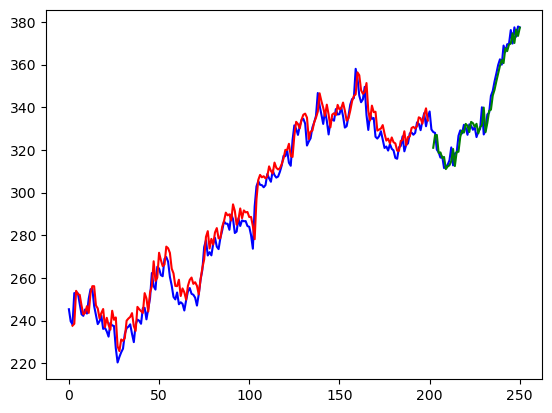

In [331]:
lookback = 2
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
model = AirModel(input_size=lookback, hidden_size=32, num_layers=1)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
 
n_epochs = 1500
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch[:, -1].reshape(-1,1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0 and epoch!=n_epochs-1:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = loss_fn(y_pred, y_train[:, -1].reshape(-1,1))
        y_pred = model(X_test)
        test_rmse = loss_fn(y_pred, y_test[:, -1].reshape(-1,1))
    print("Epoch %d: train MSE %.4f, test MSE %.4f" % (epoch, train_rmse, test_rmse))
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    train_plot[lookback:train_size] = model(X_train).reshape(1,-1)
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test).reshape(1,-1)
    print(f'R_2 train = {r2_score(y_train[:,-1], model(X_train))}')
    print(f'R_2 test = {r2_score(y_test[:,-1],  model(X_test))}')
# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

# Прогноз на основе предыдущего периода

Epoch 0: train MSE 85875.7422, test MSE 115340.8281
Epoch 100: train MSE 54711.4453, test MSE 78497.3594
Epoch 200: train MSE 18822.9805, test MSE 33125.5742
Epoch 300: train MSE 2455.9395, test MSE 6982.8911
Epoch 400: train MSE 107.4309, test MSE 821.8342
Epoch 500: train MSE 43.3155, test MSE 168.3416
Epoch 600: train MSE 36.2367, test MSE 99.0327
Epoch 700: train MSE 36.1416, test MSE 83.1003
Epoch 800: train MSE 80.2267, test MSE 115.1217
Epoch 900: train MSE 35.6419, test MSE 45.6952
Epoch 999: train MSE 26.5400, test MSE 28.8650
R_2 train = 0.9823670740796067
R_2 test = 0.933224097684552


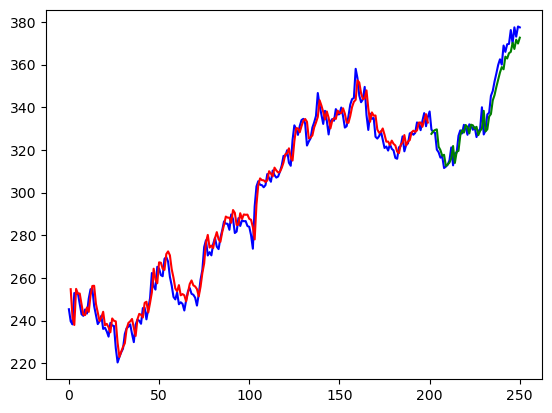

In [285]:
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
model = AirModel(input_size=lookback, hidden_size=32, num_layers=1)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
 
n_epochs = 1000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0 and epoch!=n_epochs-1:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = loss_fn(y_pred, y_train)
        y_pred = model(X_test)
        test_rmse = loss_fn(y_pred, y_test)
    print("Epoch %d: train MSE %.4f, test MSE %.4f" % (epoch, train_rmse, test_rmse))
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    train_plot[lookback:train_size] = model(X_train).reshape(1,-1)
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test).reshape(1,-1)
    print(f'R_2 train = {r2_score(y_train, model(X_train))}')
    print(f'R_2 test = {r2_score(y_test,  model(X_test))}')
# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

# Прогноз на основе 5 предыдущих периодах

Epoch 0: train MSE 86512.6172, test MSE 116202.5078
Epoch 100: train MSE 60870.4922, test MSE 86020.2578
Epoch 200: train MSE 23366.6074, test MSE 39334.2891
Epoch 300: train MSE 3489.5073, test MSE 9399.1191
Epoch 400: train MSE 391.4299, test MSE 1368.6211
Epoch 500: train MSE 42.5257, test MSE 197.7932
Epoch 600: train MSE 40.2690, test MSE 97.5147
Epoch 700: train MSE 66.9119, test MSE 43.9180
Epoch 800: train MSE 26.9512, test MSE 26.8437
Epoch 900: train MSE 42.5628, test MSE 24.0696
Epoch 999: train MSE 24.4244, test MSE 29.1686
R_2 train = 0.9836463397000255
R_2 test = 0.9357978755433645


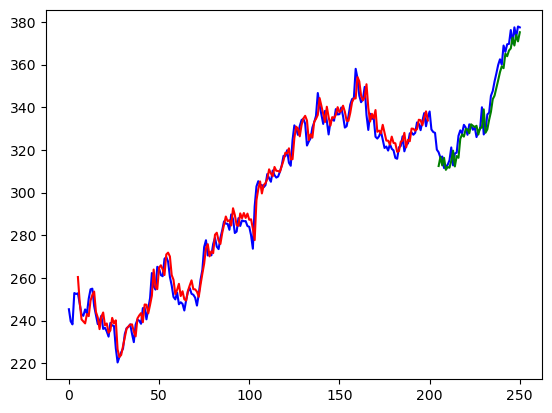

In [297]:
lookback = 5
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
model = AirModel(input_size=lookback, hidden_size=32, num_layers=1)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
 
n_epochs = 1000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch[:, -1].reshape(-1,1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0 and epoch!=n_epochs-1:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = loss_fn(y_pred, y_train[:, -1].reshape(-1,1))
        y_pred = model(X_test)
        test_rmse = loss_fn(y_pred, y_test[:, -1].reshape(-1,1))
    print("Epoch %d: train MSE %.4f, test MSE %.4f" % (epoch, train_rmse, test_rmse))
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    train_plot[lookback:train_size] = model(X_train).reshape(1,-1)
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test).reshape(1,-1)
    print(f'R_2 train = {r2_score(y_train[:,-1], model(X_train))}')
    print(f'R_2 test = {r2_score(y_test[:,-1],  model(X_test))}')
# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()